<a href="https://colab.research.google.com/github/BudhaTronix/DeepLearning-ExplainableAI/blob/main/Captum_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import and Installs**

In [ ]:
!pip install captum

In [ ]:
#Imports
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms.functional as TF

from PIL import Image
from torch import nn
from torch import optim
from torchvision import models, datasets
from torchvision import transforms

from captum.attr import LayerDeepLift
from captum.attr import LayerGradientXActivation
from captum.attr import visualization as viz

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from torch.nn import functional as F
from torch.nn import Sequential

%matplotlib inline

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#Print the grpahics card name
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla P100-PCIE-16GB


# **Common Functions**

In [ ]:
class Bottleneck(torch.nn.Module):
  def __init__(self,conv1,bn1,conv2,bn2,conv3,bn3,downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = conv1
    self.bn1 = bn1
    self.conv2 = conv2
    self.bn2 = bn2
    self.conv3 = conv3
    self.bn3 = bn3
    self.downsample = downsample

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = nn.ReLU()(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = nn.ReLU()(out)
    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = nn.ReLU()(out)

    return out

In [ ]:
 # declaring transform
data_transform = transforms.Compose([
        transforms.Resize(256),                            
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
])

In [ ]:
resModel = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()

In [ ]:
layer1 = resModel.backbone.layer1
layer2 = resModel.backbone.layer2
layer3 = resModel.backbone.layer3
layer4 = resModel.backbone.layer4

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = resModel.backbone.conv1
        self.bn1 = resModel.backbone.bn1
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool1 = resModel.backbone.maxpool
        self.layer1 = Sequential(Bottleneck(layer1[0].conv1,layer1[0].bn1,layer1[0].conv2,layer1[0].bn2,layer1[0].conv3,layer1[0].bn3,layer1[0].downsample),
                                 Bottleneck(layer1[1].conv1,layer1[1].bn1,layer1[1].conv2,layer1[1].bn2,layer1[1].conv3,layer1[1].bn3),
                                 Bottleneck(layer1[2].conv1,layer1[2].bn1,layer1[2].conv2,layer1[2].bn2,layer1[2].conv3,layer1[2].bn3))
        

        self.layer2 = Sequential(Bottleneck(layer2[0].conv1,layer2[0].bn1,layer2[0].conv2,layer2[0].bn2,layer2[0].conv3,layer2[0].bn3,layer2[0].downsample),
                                 Bottleneck(layer2[1].conv1,layer2[1].bn1,layer2[1].conv2,layer2[1].bn2,layer2[1].conv3,layer2[1].bn3),
                                 Bottleneck(layer2[2].conv1,layer2[2].bn1,layer2[2].conv2,layer2[2].bn2,layer2[2].conv3,layer2[2].bn3),
                                 Bottleneck(layer2[3].conv1,layer2[3].bn1,layer2[3].conv2,layer2[3].bn2,layer2[3].conv3,layer2[3].bn3))
        

        self.layer3 = Sequential(Bottleneck(layer3[0].conv1,layer3[0].bn1,layer3[0].conv2,layer3[0].bn2,layer3[0].conv3,layer3[0].bn3,layer3[0].downsample),
                                 Bottleneck(layer3[1].conv1,layer3[1].bn1,layer3[1].conv2,layer3[1].bn2,layer3[1].conv3,layer3[1].bn3),
                                 Bottleneck(layer3[2].conv1,layer3[2].bn1,layer3[2].conv2,layer3[2].bn2,layer3[2].conv3,layer3[2].bn3),
                                 Bottleneck(layer3[3].conv1,layer3[3].bn1,layer3[3].conv2,layer3[3].bn2,layer3[3].conv3,layer3[3].bn3),
                                 Bottleneck(layer3[4].conv1,layer3[4].bn1,layer3[4].conv2,layer3[4].bn2,layer3[4].conv3,layer3[4].bn3),
                                 Bottleneck(layer3[5].conv1,layer3[5].bn1,layer3[5].conv2,layer3[5].bn2,layer3[5].conv3,layer3[5].bn3),
                                 Bottleneck(layer3[6].conv1,layer3[6].bn1,layer3[6].conv2,layer3[6].bn2,layer3[6].conv3,layer3[6].bn3),
                                 Bottleneck(layer3[7].conv1,layer3[7].bn1,layer3[7].conv2,layer3[7].bn2,layer3[7].conv3,layer3[7].bn3),
                                 Bottleneck(layer3[8].conv1,layer3[8].bn1,layer3[8].conv2,layer3[8].bn2,layer3[8].conv3,layer3[8].bn3),
                                 Bottleneck(layer3[9].conv1,layer3[9].bn1,layer3[9].conv2,layer3[9].bn2,layer3[9].conv3,layer3[9].bn3),
                                 Bottleneck(layer3[10].conv1,layer3[10].bn1,layer3[10].conv2,layer3[10].bn2,layer3[10].conv3,layer3[10].bn3),
                                 Bottleneck(layer3[11].conv1,layer3[11].bn1,layer3[11].conv2,layer3[11].bn2,layer3[11].conv3,layer3[11].bn3),
                                 Bottleneck(layer3[12].conv1,layer3[12].bn1,layer3[12].conv2,layer3[12].bn2,layer3[12].conv3,layer3[12].bn3),
                                 Bottleneck(layer3[13].conv1,layer3[13].bn1,layer3[13].conv2,layer3[13].bn2,layer3[13].conv3,layer3[13].bn3),
                                 Bottleneck(layer3[14].conv1,layer3[14].bn1,layer3[14].conv2,layer3[14].bn2,layer3[14].conv3,layer3[14].bn3),
                                 Bottleneck(layer3[15].conv1,layer3[15].bn1,layer3[15].conv2,layer3[15].bn2,layer3[15].conv3,layer3[15].bn3),
                                 Bottleneck(layer3[16].conv1,layer3[16].bn1,layer3[16].conv2,layer3[16].bn2,layer3[16].conv3,layer3[16].bn3),
                                 Bottleneck(layer3[17].conv1,layer3[17].bn1,layer3[17].conv2,layer3[17].bn2,layer3[17].conv3,layer3[17].bn3),
                                 Bottleneck(layer3[18].conv1,layer3[18].bn1,layer3[18].conv2,layer3[18].bn2,layer3[18].conv3,layer3[18].bn3),
                                 Bottleneck(layer3[19].conv1,layer3[19].bn1,layer3[19].conv2,layer3[19].bn2,layer3[19].conv3,layer3[19].bn3),
                                 Bottleneck(layer3[20].conv1,layer3[20].bn1,layer3[20].conv2,layer3[20].bn2,layer3[20].conv3,layer3[20].bn3),
                                 Bottleneck(layer3[21].conv1,layer3[21].bn1,layer3[21].conv2,layer3[21].bn2,layer3[21].conv3,layer3[21].bn3),
                                 Bottleneck(layer3[22].conv1,layer3[22].bn1,layer3[22].conv2,layer3[22].bn2,layer3[22].conv3,layer3[22].bn3))                        
        


        self.layer4 = Sequential(Bottleneck(layer4[0].conv1,layer4[0].bn1,layer4[0].conv2,layer4[0].bn2,layer4[0].conv3,layer4[0].bn3,layer4[0].downsample),
                                 Bottleneck(layer4[1].conv1,layer4[1].bn1,layer4[1].conv2,layer4[1].bn2,layer4[1].conv3,layer4[1].bn3),
                                 Bottleneck(layer4[2].conv1,layer4[2].bn1,layer4[2].conv2,layer4[2].bn2,layer4[2].conv3,layer4[2].bn3))
        
        self.layer5 = resModel.classifier
        #self.layer6 = resModel.aux_classifier

    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        op_max = torch.argmax(x,dim=1, keepdim=True)
        selected_inds = torch.zeros_like(x[0:]).scatter_(1, op_max, 1)
        return (x * selected_inds).sum(dim=(2,3))

        #return self.layer6(x)  
        #return x

In [ ]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=21):  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
def wrapper(inp):
  model_out = resModel(inp)['out']
  # Creates binary matrix with 1 for argmax class for each pixel
  # and 0 otherwise.
  selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
  return (model_out * selected_inds).sum(dim=(2,3))


# Alternate wrapper, simply summing each output channel
# def wrapper(inp):
#   return fcn(inp)['out'].sum(dim=(2,3))

In [ ]:
copyNet = Net()
_ = copyNet.to(device).eval() 

In [ ]:
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize(300), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

!wget -nv https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg -O city.png

img = Image.open("city.png")
preproc_img = preprocessing(img)
plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off'); plt.show()

op = resModel(torch.unsqueeze(preproc_img.to(device), 0))['out']
print(op[:,0,:,:])

# Normalize image and compute segmentation output
normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
out = resModel(normalized_inp)['out']

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb); plt.axis('off'); plt.show()

# **Functions** 

In [ ]:
def captum_LayerGradientXActivation(forward_func, selected_layer, inp_image, target, signs, methods):
  lgc = LayerGradientXActivation(forward_func, selected_layer)

  gc_attr = lgc.attribute(inp_image, target)

  la = LayerActivation(forward_func, selected_layer)
  activation = la.attribute(inp_image)


  viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),method=methods,sign=signs,show_colorbar=True, title="Captum Layer Gradient X Activation")

In [ ]:
def captum_LayerGradCam(forward_func, selected_layer, inp_image, target, signs, methods):
  lgc = LayerGradCam(forward_func, selected_layer)
  gc_attr = lgc.attribute(inp_image, target)

  la = LayerActivation(forward_func, selected_layer)
  activation = la.attribute(inp_image)

  viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),method=methods,sign=signs,
                                                show_colorbar=True, title="Captum Layer GradCam")

In [ ]:
def captum_LayerDeepLift(forward_func, inp_image, selected_target, signs, methods):
 # _ = forward_func.to(device).eval() 
  LdLift = LayerDeepLift(forward_func,forward_func.layer4[2].conv3)
  # Deep lift for person class
  LdLift_attribution = LdLift.attribute(inp_image, target=selected_target)

  grads = np.transpose(LdLift_attribution.squeeze().cpu().detach().numpy(), (1, 2, 0))
  original_image = np.transpose(inp_image.squeeze().cpu().detach().numpy(), (1, 2, 0))


  _ = viz.visualize_image_attr(grads, original_image, method=methods, sign=signs,
                              show_colorbar=True, title="Captum Layer Deep Lift ")

# **Function Calls**

/usr/local/lib/python3.6/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Input Shape: torch.Size([1, 3, 300, 452])
Layer Activation Shape: torch.Size([1, 2048, 38, 57])
Layer GradientX Shape: torch.Size([1, 2048, 38, 57])


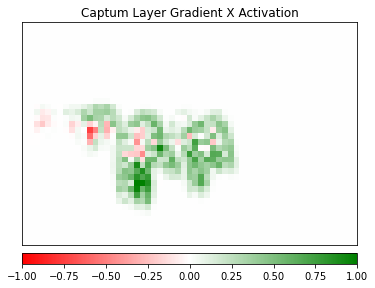

In [ ]:
#Layer Gradient X Activation
forward_func = wrapper
target = 15
sign = "all" #["all", "positive", "negative"]
method = "heat_map" #["original_image", "blended_heat_map","blended_heat_map"]
image = normalized_inp
selected_layer = resModel.backbone.layer4[2].conv3

#Function Call: 
captum_LayerGradientXActivation(forward_func, selected_layer, image, target, sign, method)

/usr/local/lib/python3.6/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


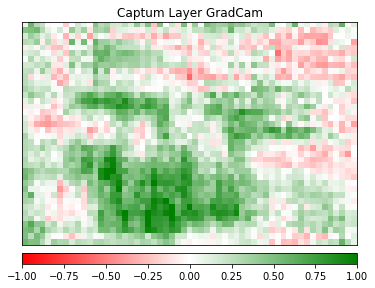

In [ ]:
#Layer Gradcam
forward_func = wrapper
target = 15
sign = "all" #["all", "positive", "negative"]
method = "heat_map" #["original_image", "blended_heat_map","blended_heat_map"]
image = normalized_inp
selected_layer = resModel.backbone.layer4[2].conv3

#Function Call: 
captum_LayerGradCam(forward_func, selected_layer, image, target, sign, method)

/usr/local/lib/python3.6/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


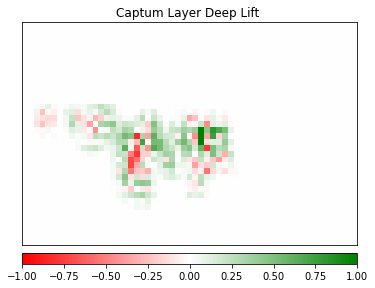

In [ ]:
#Layer Deep Lift

image = normalized_inp
forward_func = Net()
_ = forward_func.to(device).eval() 
target = 15
sign = "all" #["all", "positive", "negative"]
method = "heat_map" #["original_image", "blended_heat_map","blended_heat_map"]

#Function Call: 
captum_LayerDeepLift(forward_func, image, target, sign, method)

# **XML**

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "captum_LayerGradientXActivation",  
                       "library" : "captum",
                       "inpt_transform_req" : True,
                       "target" : [15],
                       "aux_func_flag" : True,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "LayerGradientXActivation",
                       "device_id" : "cuda:0",
                       "keywords": {"cnn layer": layer4[2].conv3}
                     }]}

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "captum_LayerGradCam",  
                       "library" : "captum",
                       "inpt_transform_req" : True,
                       "target" : [15],
                       "aux_func_flag" : True,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "LayerGradCam",
                       "device_id" : "cuda:0",
                       "keywords": {"cnn layer": layer4[2].conv3}
                     }]}

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "captum_LayerDeepLift",  
                       "library" : "captum",
                       "inpt_transform_req" : True,
                       "target" : [15],
                       "aux_func_flag" : True,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "LayerDeepLift",
                       "device_id" : "cuda:0",
                     }]}